# Suggesting how a project can be improved

**Goal: Determine and validate a method to compare the most predictive meta features of a project with those of the average top performing project to serve as areas for improvement.**

In [1]:
# Load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import feature_engineering
from scipy import sparse
from sklearn.externals import joblib

# Set figure display options
%matplotlib inline
sns.set(context='notebook', style='darkgrid')
sns.set(font_scale=1.4)

Let's begin loading the pre-trained scaler, vectorizer and classifier.

In [2]:
# Load serialized scaler and vectorizer
scaler = joblib.load('data/trained_models/trained_scaler.pkl')
vectorizer = joblib.load('data/nlp/vectorizer_250.pkl')

# Load model pretrained on meta features and n-grams
clf = joblib.load('data/trained_models/trained_classifier.pkl')

We need to define which meta features we want to provide recommendations for. Let's select the meta features that were most predictive of funded projects: # of hyperlinks, # of images, # of innovation words, # of exclamation marks, % of bolded text, and # of words. We'll ignore the features that were most predictive of *unfunded* projects (average words per sentence and average sentences per paragraph) since they are less interpretable and more difficult to tweak for creators.

In [3]:
# List of meta features
features = ['num_sents', 'num_words', 'num_all_caps', 'percent_all_caps',
            'num_exclms', 'percent_exclms', 'num_apple_words',
            'percent_apple_words', 'avg_words_per_sent', 'num_paragraphs',
            'avg_sents_per_paragraph', 'avg_words_per_paragraph',
            'num_images', 'num_videos', 'num_youtubes', 'num_gifs',
            'num_hyperlinks', 'num_bolded', 'percent_bolded']

# List of meta features that were most predictive of funded projects
predictive_features = ['num_hyperlinks', 'num_images', 'num_apple_words',
                       'num_exclms', 'percent_bolded', 'num_words']

Let's load the training set from PostgreSQL so we can determine the top performing projects.

In [4]:
# Set database credentials
db_name1 = 'section1_db'
usernm = 'redwan'
host = 'localhost'
port = '5432'
#pwd = ''

# Prepare a connection to database contaning the "About this project" section
con1 = psycopg2.connect(
    database=db_name1, 
    host='localhost',
    user=usernm,
    password=pwd
)

# Query all data from the database
sql_query1 = 'SELECT * FROM section1_db;'
section1_df_full = pd.read_sql_query(sql_query1, con1)

To define a metric for how successful a project was, we'll use the percent above or below the project goal reached by each project. Next, we'll select the projects in the top 5%, and then finish by cleaning the data.

In [5]:
# Define a variable for defining top performing projects
section1_df_full['percent_funded'] = section1_df_full['pledged'] / \
    section1_df_full['goal']

# Select projects that are within the top 5%
quantile_limit = section1_df_full['percent_funded'].quantile(q=0.95)
top_projects = section1_df_full[section1_df_full['percent_funded'] >= \
                                quantile_limit]

# Select meta features for top projects
X = top_projects[features]

# Remove all rows with no data
X_cleaned = X[~X.isnull().all(axis=1)]

# Fill remaining missing values with zero
X_cleaned = X_cleaned.fillna(0)

To aggregate the top performing projects, we'll compute the mean of the values for each meta feature. Next, we'll standardize the averaged meta features using the scaler trained on the training set.

In [6]:
# Compute the average meta feature of the top projects
avg_top_projects = X_cleaned.mean()

# Standardize the meta features for the average top project
top_project_std = pd.Series(
    scaler.transform([avg_top_projects]).ravel(),
    index=features
)

Let's save the standardized meta features of the average top project.

In [7]:
# Save the top project vector
#joblib.dump(top_project_std, 'top_5_percent_vector.pkl')

# Alternatively load the feature vector for the average top project
#top_project_std = joblib.load('data/top_5_percent_vector.pkl')

Let's select a project to test.

In [8]:
# Select a hyperlink
hyperlink = 'https://www.kickstarter.com/projects/getpebble/pebble-2-ti' + \
    'me-2-and-core-an-entirely-new-3g-ultra'

We need to scape the project page, collect the campaign, and extract meta features. Next, we'll use the scaler trained on the training set to standardize the meta features.

In [9]:
# Compute the meta features and preprocess the campaign section
meta_features, processed_section = feature_engineering.process_project(
    hyperlink
)

# Standardize the feature vector
feature_vector_std = pd.Series(
    scaler.transform([meta_features]).ravel(),
    index=features
)

Using the classifier, let's extract the feature importances.

In [10]:
# Compute meta feature ranks
feature_ranks = pd.Series(
    clf.coef_.T.ravel()[:len(features)],
    index=features
)

To determine how effectively the project utilized each meta feature, let's define the a weighted score for each of the most predictive meta features by multiplying its parameter value by the standardized value of that meta feature. High, positive values of the weighted score indicate that the project utilized this meta feature effectively. High, negative values indicate the project did not use that meta feature effectively. 

Finally, we'll repeat these computations for the average top performing project, which will serve as the gold standard.

In [11]:
# Compute the weighted score of the meta features of a project
user_project_score = np.multiply(
    feature_vector_std[predictive_features],
    feature_ranks[predictive_features]
)

# Compute the weighted score of the meta features of the average top project
top_project_score = np.multiply(
    top_project_std[predictive_features],
    feature_ranks[predictive_features]
)

To visualize the two weighted scores in Seaborn, we need to transform the dataset into tidy format.

In [12]:
# Combine the weighted scores into a single DataFrame
messy = pd.DataFrame(
    [user_project_score, top_project_score], 
    index=['Your project', 'Top projects']
).T.reset_index()

# Transform the combined data into tidy format
tidy = pd.melt(
    messy,
    id_vars='index',
    value_vars=['Your project', 'Top projects'],
    var_name=' '
)

Finally, let's draw a grouped bar plot of the weighted scores. This graph serves to provide the project creator with actionable insights for improving their project's campaign and demonstrating which meta feature tweaks will yield the highest ROI and increase their chance of reaching funding goal.

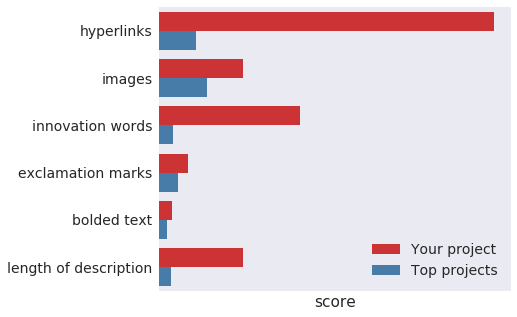

In [13]:
# Draw a grouped bar plot of the weighted scores
fig = sns.factorplot(
    data=tidy,
    y='index',
    x='value',
    hue=' ',
    kind='bar',
    size=5,
    aspect=1.5,
    palette='Set1',
    legend_out=False
).set(
    xlabel='score',
    ylabel='',
    xticks=[]
)

# Re-label the y-axis and reposition the legend
labels = ['hyperlinks', 'images', 'innovation words', 'exclamation marks',
          'bolded text', 'length of description']
plt.yticks(np.arange(len(predictive_features)), labels)
fig.ax.legend(loc='lower right');
#plt.savefig('figure.png', bbox_inches='tight', dpi=300);